In [276]:
import numpy as np
import matplotlib.pyplot as plt
import random

def loaddata(file):
    with open(file, 'r') as fo:      
        data = np.loadtxt(fo, dtype=np.float32)
    return data


def onehot_encode(Label):
    Lab=np.unique(Label)
    L=np.zeros((len(Label),len(Lab)))
    for i in range(len(Label)):  
        for j in range(len(Lab)):
            if Label[i]==Lab[j]:
                L[i,j]=1
    return L

def normdata (data):         # normalize data to (-1,1)
    m=np.mean(data,axis=0)   
    k=np.max(data,axis=0)-np.min(data,axis=0)
    Ndata=(data-m)/k 
    return Ndata


def softmax(x):
    exp_x=np.exp(x-np.max(x))
    partition=np.sum(exp_x,axis=1,keepdims=True)
    return exp_x/partition

# compute loss and gradW         
def softloss (Y,X,W,grad_):
    linear=np.dot(X,W)         
    P=softmax(linear)
    Reg=0.5*alpha*(np.linalg.norm(W)**2)   # L2 norm
    SoftLoss=-np.sum(Y*np.log(P))+Reg    
    grad=mtum*grad_[-1]+np.dot(X.T,(P-Y))+alpha*W   #    
    return SoftLoss,grad
   

def Acc_compute(X,Y,W):  
    
    Y_pred=softmax(np.dot(X,W))      #N*3
    N=Y_pred.shape[0]   
    count= np.sum(np.argmax(Y_pred, axis=1)==np.argmax(Y, axis=1))  # as row  axis=1
    acc=count/N
    return acc  

def data_processing(data):
    #normalize data and add bias, #data formate first col is label    
    NormD=normdata (data[:,1:data.shape[1]])   
    bias1=np.ones((data.shape[0],1)) 
    B_data=np.c_[bias1,NormD]
    Label=onehot_encode(data[:,0]) 
    return B_data, Label




In [415]:
# load data 
traindata = loaddata('/Users/dl/Documents/RIT related/Iris/iris-train.txt')
testdata=loaddata('/Users/dl/Documents/RIT related/Iris/iris-test.txt')

# Tune Parameters 
Epochs=1000
N=traindata.shape[0] # 90
Mini=20
BSize=N//Mini   #9
alpha= 0.01   # weight decay
rate=5e-3  # rate
mtum=0.01  #momentum rate
grad_=[0]
W=np.random.uniform(low=-1, high=1, size=9).reshape(3,3)  # initialize W (X_col dim, Y_col dim)

 
# statistic variable
Sta_trAcc=[]
Sta_tsAcc=[]
loss1=[]
loss2=[]

# train model 
for m in range(Epochs):
    
    np.random.shuffle(traindata)  #shuffle 
    
    #normalize data and add bias
    NormTr,TrainL=data_processing(traindata)
    NormTs,TestL=data_processing(testdata)       
    
    # update W in train minibatch
    for i in range(BSize):
        X=NormTr[Mini*i:Mini*(i+1),:]
        Y=TrainL[Mini*i:Mini*(i+1),:]
        Loss,grad=softloss(Y,X,W,grad_)
        W=W-rate*grad                   
        grad_=np.append(grad_,grad)        
      
    #Loss and Accuracy compute of train sets
    TAcc=Acc_compute(NormTr,TrainL,W)      
    TLoss,grad1=softloss(TrainL,NormTr,W,grad_)
    loss1=np.append(loss1,TLoss)
    #print(TLoss)
   
    #Loss and Accuracy compute of test sets
    SAcc=Acc_compute(NormTs,TestL,W)    
    SLoss,grad2=softloss(TestL,NormTs,W,grad_)    
    loss2=np.append(loss2,SLoss)
    
    #statistic Acc during epoches 
    Sta_trAcc=np.append(Sta_trAcc,TAcc)
    Sta_tsAcc=np.append(Sta_tsAcc,SAcc)
    
    #early stopping 
    if m>2 and loss1[-2] - loss1[-1]<1e-3:  #0.01
        rate=rate*0.8
        if rate< 1e-11:
            break
    #print(m,'Epoches--','Loss:',TLoss/N,'Accuracy',TAcc)


print(W)
print(TLoss,SLoss)
print(TAcc,SAcc)

[[-0.53124054 -0.11089277 -0.51059776]
 [-2.47898295  0.5776865   1.91917352]
 [-6.32952508  0.87585489  4.89640545]]
61.88316791804082 24.17661739749588
0.8444444444444444 0.7254901960784313


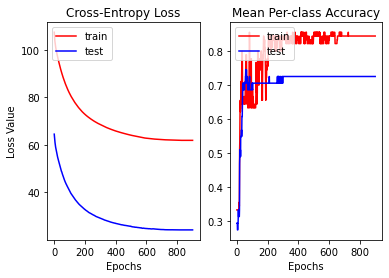

In [416]:

#plot loss and Accuracy 
def plot_loss_accuracy (loss1,loss2,Sta_trAcc,Sta_tsAcc):
    plt.subplot(1,2,1)
    A=np.arange(0,loss1.shape[0],1)
    plt.plot(A,loss1,'-r')
    plt.plot(A,loss2,'-b')
    plt.legend(('train', 'test'), loc='upper left') 
    plt.title('Cross-Entropy Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')

    plt.subplot(1,2,2)
    plt.plot(A,Sta_trAcc,'-r')
    plt.plot(A,Sta_tsAcc,'-b')
    plt.title('Mean Per-class Accuracy')
    plt.xlabel('Epochs')
    #plt.ylabel('Accuracy')
    plt.legend(('train', 'test'), loc='upper left') 
    plt.show()
plot_loss_accuracy(loss1,loss2,Sta_trAcc,Sta_tsAcc)

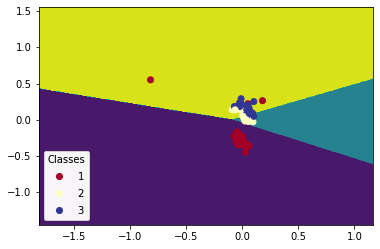

In [376]:
#Part2
#plot decision boundary 
def descision_boundary(traindata):
    y=traindata[:,0]
    X=normdata (traindata[:,1:traindata.shape[1]])   #N*2
    X1=X[:,0]
    X2=X[:,1]
    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    #get Z based model 
    b=np.ones(xx.ravel().shape[0])
    data=np.array([xx.ravel(), yy.ravel()]).T
    data=np.c_[b,data]
    Z=np.argmax(softmax(np.dot(data,W)), axis=1)
    Z = Z.reshape(xx.shape)
    
    #plot boundary and scatter 
    fig,ax = plt.subplots()
    boundary=ax.contourf(xx, yy, Z,)
    scatter = ax.scatter(X1, X2, c=np.squeeze(y), cmap=plt.cm.RdYlBu)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.show() 

#plot decision boundary
descision_boundary(traindata)    

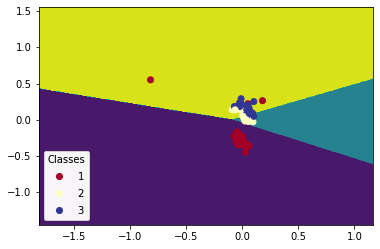

In [377]:
#Part2
#plot decision boundary 
def descision_boundary(traindata):
    y=traindata[:,0]
    X=normdata (traindata[:,1:traindata.shape[1]])   #N*2
    X1=X[:,0]
    X2=X[:,1]
    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    #get Z based model 
    b=np.ones(xx.ravel().shape[0])
    data=np.array([xx.ravel(), yy.ravel()]).T
    data=np.c_[b,data]
    Z=np.argmax(softmax(np.dot(data,W)), axis=1)
    Z = Z.reshape(xx.shape)
    
    #plot boundary and scatter 
    fig,ax = plt.subplots()
    boundary=ax.contourf(xx, yy, Z,)
    scatter = ax.scatter(X1, X2, c=np.squeeze(y), cmap=plt.cm.RdYlBu)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.show() 

descision_boundary(traindata)

In [178]:
W

array([[-0.74452157, -0.52843342, -0.70297246],
       [-0.74676805,  0.3015175 ,  0.43735828],
       [-4.1380104 ,  0.58404704,  3.043103  ]])

In [244]:
#Part2
#plot decision boundary 
def descision_boundary(traindata)
    y=traindata[:,0]
    X=normdata (traindata[:,1:traindata.shape[1]])   #N*2
    X1=X[:,0]
    X2=X[:,1]

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 

    #get Z based model 
    b=np.ones(xx.ravel().shape[0])
    data=np.array([xx.ravel(), yy.ravel()]).T
    data=np.c_[b,data]
    Z=np.argmax(softmax(np.dot(data,W)), axis=1)
    Z = Z.reshape(xx.shape)

    fig,ax = plt.subplots()
    boundary=ax.contourf(xx, yy, Z,)

    scatter = ax.scatter(X1, X2, c=np.squeeze(y), cmap=plt.cm.RdYlBu)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

    plt.show() 

SyntaxError: invalid syntax (<ipython-input-244-04d81cb32a4b>, line 3)